# **Assignement 2 : Machine Translation 1**

## L'Hoest Julien, Libert Robin, Vieslet Thomas

## Model overview

The task of this project is to implement a machine translation system using RNN and compare the results of 3 different embeddings: word2vec, fasttext and glove. We decided to apply the translation from German to English.

### Pre-processing

The dataset on which the training is applied on a medical dataset from German to English (.tmx file). This dataset is cleaned and converted into CSV file. The cleaning applied consists in:

* Replacing numbers and punctuations by spaces which will be dropped by the tokenization step
* Converting in lower case when needed by embedding
* Dropping the sentence that are longer than a given threshold

The chosen emmbedding is then loaded in the *Preprocess* object. The corresponding vectors are stored in the EN_vec and DE_vec. Some adjustements, sometimes, are needed depending on the initial embedding format.

The dataset is then split between the test and the train set according to the previous specifications. Using the Field object of torchtext, a vocabulary is built on the training data for each language. A vocabulary maps the words of the training set to the corresponding vectors in the embedding. The embedding vectors are pretrained and supposed to capture the semantic of the corresponding word through their high dimension (size 300). 2 list of vocabulary are obtained.

### Architecture

The system we implemented is based on the classical encoder/decoder architecture for machine translation and the used RNN are based on Long Short-Term Memory (LSTM) architecture. The hyper-parameters of the model are conventional ones whose relative efficiency could be considered on this page of result : https://medium.com/@vina.wt.chang/hyperparameter-tuning-for-nmt-af44fbcecccb.

#### Encoder

The Encoder RNN is initiated with usual parameters: *input_size* (2000), *embedding_size* (300), *hidden_size* (1024), *number of layers* (2) and *the dropout* (0.5). The german embeddings are also stored in the encoder object. The training of the Encoder proceed as follow:

* The first block of the Encoder is taking care of mapping the indexed input word to the corresponding embedding vector

* Afterwards, each word vector of the input sequence go through the RNN (of 2 layers) and is combined with the hidden and cell states of the previous time step.
* When the whole sequence of word is gone through the LSTM, the obtained hidden and cell states compose 2 context vectors for the input sequence.

This sequence can be passed to the decoder for translation to English

#### Decoder

The Decoder must be initiated with the same parameters as the Encoder. However, an additionnal linear layer is added in the end of the RNN for probability computation.  The training of the decoder proceed as follow:

* The context vector obtained from the decoder is fed to the network as hidden and cell states and a "Start Of Sequence" token is fed as input
* After being combined with the context vector and going through the linear layer, probabilities for all the vocalubary word are computed and the one with highest probability is chosen.
* Next, two situations are possible (depending on the teacher force ratio): the output with the highest probability of previous iteration is the input or the input is the true English word (very important for the model to be trained efficiently). In both cases, the hidden and cell states from the previous LSTM cellare used as input.

#### Seq2seq

The overall training process is simply composed of the following steps:

* Provide the Encoder with the input sequences (German) of the dataset and iterate until the End Of the Sequence is reached.
* Provide the Decoder with the context vectors of the sequence obtained from the Encoder to produce an the most probable output and use it together with the actual English words of the sequence to train the decoder.
* Iterate over all the sequences of the datatset.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, BucketIterator
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint,\
    DataFrameDataset, DE_sentence_to_bytes_representation_string, clean_sentence
import parameters as PRM
from preprocess import Preprocess
import random
import pickle

### Prepare dataset

* Choose embeddings fasttext or glove or word2vec
* Load the dataset then drop the sentences with a length > 20
* We took 100000 sentences from the dataset before preprocessing

In [2]:
choose_embeddings = 'fasttext'
# choose_embeddings = 'glove'
# choose_embeddings = 'word2vec'

# Reference to data
preprocessing = Preprocess()
preprocessing.load_wiki()
# Drop pairs which are too long
preprocessing.drop_longest_wiki_sentences()

* In the cell below, we load the embeddings and create the training and testing set.
* After some proprocessing on the dataset, we obtained a training set of length 45306 and a testing set of length 19417

In [3]:
if choose_embeddings == 'fasttext':
    preprocessing.load_fasttext()
    DE_lower, EN_lower, special_token_initiated = False, True, True
elif choose_embeddings == 'glove':
    preprocessing.load_glove()
    DE_lower, EN_lower, special_token_initiated = True, True, False
elif choose_embeddings == 'word2vec':
    preprocessing.load_word2vec()
    DE_lower, EN_lower, special_token_initiated = True, True, False

# Check for the German word2vec embedding with bytes representation
if preprocessing.bytes_representation_for_DE_word:
    preprocessing.sentences[PRM.SOURCE] = preprocessing.sentences[PRM.SOURCE]\
        .apply(DE_sentence_to_bytes_representation_string)



german = Field(lower=DE_lower,
               init_token=PRM.SOS_TOKEN, eos_token=PRM.EOS_TOKEN, pad_token=PRM.PAD_TOKEN, unk_token=PRM.UNK_TOKEN)

english = Field(lower=EN_lower,
                is_target=True,
                init_token=PRM.SOS_TOKEN, eos_token=PRM.EOS_TOKEN, pad_token=PRM.PAD_TOKEN, unk_token=PRM.UNK_TOKEN)

random.seed(0)  # Set seed for reproducibility purposes
rnd = random.getstate()

train_data, test_data = DataFrameDataset(
    df=preprocessing.sentences,
    fields=[
        (PRM.SOURCE, german),
        (PRM.TARGET, english)
    ]
).split(split_ratio=PRM.SPLIT_RATIO, random_state=rnd)

print('Length of the training dataset: ',len(train_data))
print('Length of the testing dataset: ',len(test_data))

Length of the training dataset:  45306
Length of the testing dataset:  19417


### Create the vocabulary

In [4]:
german.build_vocab(train_data,
                   max_size=PRM.VOCAB_LENGTH, min_freq=PRM.MIN_VOCAB_FREQ, vectors=preprocessing.DE_vec)
english.build_vocab(train_data,
                    max_size=PRM.VOCAB_LENGTH, min_freq=PRM.MIN_VOCAB_FREQ, vectors=preprocessing.EN_vec)

# Assign default vector value for the begin and enc of sentence token
if not special_token_initiated:
    german.vocab.vectors[german.vocab.stoi[PRM.SOS_TOKEN]] = PRM.SOS_TOKEN_VEC
    english.vocab.vectors[english.vocab.stoi[PRM.SOS_TOKEN]] = PRM.SOS_TOKEN_VEC

    german.vocab.vectors[german.vocab.stoi[PRM.EOS_TOKEN]] = PRM.EOS_TOKEN_VEC
    english.vocab.vectors[english.vocab.stoi[PRM.EOS_TOKEN]] = PRM.EOS_TOKEN_VEC

### Model Architecture
* We used the script seq2seq.py to perform the trainings with the 3 different types of embeddings.

In [5]:
class Encoder(nn.Module):
    def __init__(self, german_field, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, PRM.DIM_VEC).from_pretrained(torch.FloatTensor(german_field.vocab.vectors))
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        return hidden, cell


class Decoder(nn.Module):
    def __init__(
        self, english_field, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, PRM.DIM_VEC).from_pretrained(torch.FloatTensor(english_field.vocab.vectors))
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        PRM.BATCH_SIZE = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(target_len, PRM.BATCH_SIZE, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

### Load the model and some data obtained during the training phase in order to perform an analysis.

In [6]:
# Model hyperparameters
load_model = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_size = len(german.vocab)
output_size = len(english.vocab)  # The input size has been defined implicitly by the embedding layers
embedding_size = PRM.DIM_VEC
hidden_size = PRM.HIDDEN_SIZE  # Needs to be the same for both RNN's
num_layers = PRM.NUM_LAYERS
enc_dropout = PRM.ENC_DROPOUT
dec_dropout = PRM.DEC_DROPOUT

# Tensorboard to get nice loss plot
writer = SummaryWriter(f"runs/loss_plot")
step = 0

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=PRM.BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(getattr(x, PRM.SOURCE)),  # To save computation resourcing with the padding
                                                    # (have batch with similar sentences lenghts)
    device=device,
)

encoder_net = Encoder(
    german, input_size, embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    english,
    input_size,
    embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=PRM.LEARNING_RATE)

pad_idx = english.vocab.stoi[PRM.PAD_TOKEN]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# pickle save system
loss_history = []
translated_sentence_history = []

if load_model:
    load_checkpoint(torch.load(f"results/{choose_embeddings}/my_checkpoint.pth.tar"), model, optimizer)
    with open(f'results/{choose_embeddings}/loss_history.pkl', 'rb') as f:
        loss_history = pickle.load(f)
    with open(f'results/{choose_embeddings}/translated_sentence_history.pkl', 'rb') as f:
        translated_sentence_history = pickle.load(f)

sentence = clean_sentence("Wenn etwas Alkohol auf der Haut verbleibt  können Sie ein brennendes Gefühl verspüren",
                          lower_sentence=DE_lower,
                          bytes_representation_for_DE_word=preprocessing.bytes_representation_for_DE_word)
print(sentence)
print(clean_sentence("If a bit of alcohol is left on the skin  you may get a stinging sensation ",
                     lower_sentence=EN_lower))

cuda
=> Loading checkpoint
Wenn etwas Alkohol auf der Haut verbleibt  können Sie ein brennendes Gefühl verspüren
if a bit of alcohol is left on the skin  you may get a stinging sensation 


### Loss plot data
* Our training dataset have a size of 45306. We trained each model over 50 epoch with a batch size of 32.
* We computed the loss during the 3 training over the 50 epochs and for each batch which means about 70790 loss data for each training.

In [ ]:
import analysis as analysis
analysis.plot_loss_history('fasttext')
analysis.plot_loss_history('glove')
analysis.plot_loss_history('word2vec')

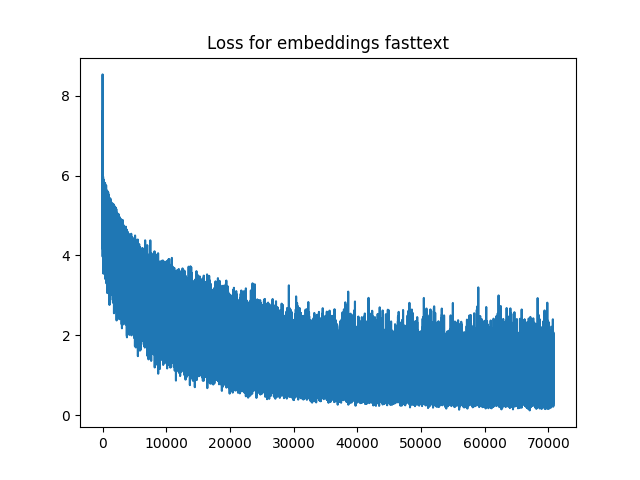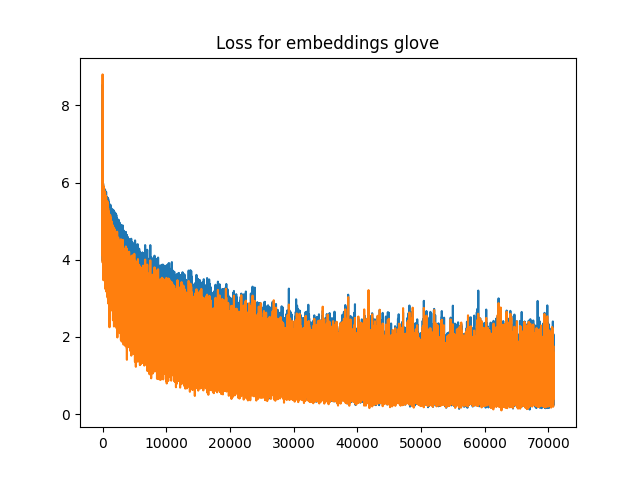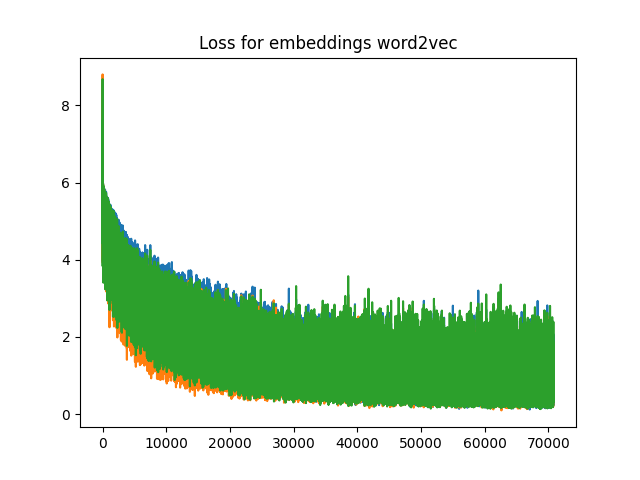

### Translations comparisons

* We use a sentence during the training phase in order to see the evolution of the translations after each epoch.
* Original sentence: Wenn etwas Alkohol auf der Haut verbleibt  können Sie ein brennendes Gefühl verspüren
* Expected translation: If a bit of alcohol is left on the skin  you may get a stinging sensation

In [8]:
print('Fasttext translations:')
print()
analysis.print_sentences('fasttext')
print()
print('Glove translations:')
print()
analysis.print_sentences('glove')
print()
print('Word2vec translations:')
print()
analysis.print_sentences('word2vec')
print()

Fasttext translations:

Epoch  1 :  ['if', 'you', 'are', '<unk>', 'to', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  2 :  ['if', 'you', 'have', 'any', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  3 :  ['if', 'you', '<unk>', '<unk>', '<unk>', 'or', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  4 :  ['if', 'you', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  5 :  ['if', 'you', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  6 :  ['if', 'any', '<unk>', '<unk>', 'or', '<unk>', 'the', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  7 :  ['if', 'the', '<unk>', '<unk>', 'your', 'skin', 'or', '<unk>', '<unk>', '</e>']
Epoch  8 :  ['if', 'your', '<unk>', '<unk>', 'your', '<unk>', 'or', '<unk>', '<unk>', '</e>']
Epoch  9 :  ['if', 'the', '<unk>', '<unk>', 'your', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</e>']
Epoch  10 :  ['if', 'the', '<unk>', '<unk>', 'the', 'ski

### Small example of the first 10 sentences of the testing set.
* Original sentence
* Expected translation
* Our translation with fasttext

In [9]:
for example in test_data[1:10]:
        src = vars(example)[PRM.SOURCE]
        trg = vars(example)[PRM.TARGET]
        prediction = translate_sentence(model, src, german, english, device)
        print(src)
        print(trg)
        print(prediction)
        print()

['Bevor', 'der', 'Patient', 'in', 'andere', 'Zeitzonen', 'reist', 'sollte', 'er', 'sich', 'mit', 'seinem', 'Arzt', 'beraten']
['before', 'travelling', 'between', 'different', 'time', 'zones', 'the', 'patient', 'should', 'seek', 'the', 'doctor', 's', 'advice']
['<unk>', 'treatment', 'be', '<unk>', 'patient', 'in', 'patients', 'with', '<unk>', 'when', '<unk>', 'when', 'your', 'doctor', '</e>']

['Wechselwirkungen', 'mit', 'anderen', 'Arzneimitteln']
['interactions', 'with', 'other', 'medicinal', 'products']
['medicinal', 'product', 'subject', 'to', 'medical', 'prescription', '</e>']

['Die', 'erste', 'Injektion', 'von', 'Bemfola', 'muss', 'unter', 'Aufsicht', 'Ihres', 'Arztes', 'erfolgen']
['the', 'first', 'injection', 'of', 'bemfola', 'should', 'be', 'given', 'under', 'supervision', 'of', 'your', 'doctor']
['the', 'first', 'injection', 'of', 'bemfola', 'is', '<unk>', 'under', 'the', 'doctor', '</e>']

['Verwirrtheit']
['confusion']
['<unk>', '</e>']

['Phantasiename']
['invented', 'name

### Computation of the blue score with our testing set
* We decided to compute the blue score only with the first 100 sentences of our testing set due to some time constraints.

In [10]:
score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

Bleu score 20.28


### Blue score with fasttext embeddings: 20.28
### Blue score with glove embeddings: 20.21
### Blue score with word2vec embeddings: 0